
## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

# imports + functions

In [3]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 torchtext==0.12.0 torchdata==0.3.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling to

In [4]:
%%capture
!pip install datasets
!pip install tokenizers
!pip install transformers
!pip install torchinfo
!pip install evaluate
!pip install trl

In [5]:
import datasets
import torch
from torch.utils.data import DataLoader
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from torchinfo import summary
import time
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import math
import torchtext
from torch.utils.data import DataLoader
from tokenizers import ByteLevelBPETokenizer, BertWordPieceTokenizer
import tokenizers
from transformers import (GPT2Tokenizer, BertTokenizer, BertModel, BertConfig, GPT2LMHeadModel, GPT2Config, EncoderDecoderModel, 
                          Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback, GenerationConfig, AutoTokenizer,
                          EncoderDecoderConfig)
from trl import AutoModelForSeq2SeqLMWithValueHead, PPOConfig, PPOTrainer, create_reference_model
import evaluate
from google.colab import drive

In [6]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [7]:
def dataset_generator(dataset, language):
    for row in dataset:
        yield row['translation'][language]

In [8]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = token_ids_0 + [self.eos_token_id]
    return outputs

In [9]:
def get_grad_norm(model_params):
    norm = 0
    for _, p in model_params:
        try:
            norm += torch.linalg.norm(p.grad.detach().data).item()**2
        except:
            pass
    return norm**0.5

In [10]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [11]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
class EarlyStopping:
    """Early stops the training if validation metric doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation metric improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation metric improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_metric_max = 0
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_metric, model):

        score = val_metric

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_metric, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_metric, model)
            self.counter = 0

    def save_checkpoint(self, val_metric, model):
        '''Saves model when validation metric increase.'''
        if self.verbose:
            self.trace_func(f'Validation metric increased ({self.val_metric_max:.3f} --> {val_metric:.3f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_metric_max = val_metric

In [13]:
SEED = 123
TRAIN_SIZE = 0.9
MIN_TOKEN_FREQ = 3
UNK_TOKEN = "[UNK]"
BOS_TOKEN = "[BOS]"
EOS_TOKEN = "[EOS]"
PAD_TOKEN = "[PAD]"
BATCH_SIZE = 128

# Load dataset

In [28]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [29]:
dataset = datasets.load_dataset("text", data_files=path_do_data)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-314ad6f179707e1e/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
dataset = dataset["train"].map(lambda text, i: {"id": i, "translation": {"en": text['text'].split('\t')[0], "ru": text['text'].split('\t')[1]}},
                                   remove_columns=["text"],
                                   features=datasets.Features({"id": datasets.Value("string"), "translation": datasets.Translation(languages=["en", "ru"])}),
                                   with_indices=True,
                                   )

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [31]:
dataset[:10]

{'id': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 'translation': [{'en': 'Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.',
   'ru': 'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.'},
  {'en': 'At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.',
   'ru': 'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.'},
  {'en': 'Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.',
   'ru': 'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.'},
  {'en': 'Each has a TV and a private bathroom with shower.',
   'ru': 'В вашем распоряжении также телевизор и собственная ванная комната с душем.'},
  {'en': 'Your room comes with air conditioning and satellite TV.',
   'ru': 'Номер оснащен кондиционером и сп

In [32]:
train_test_dataset = dataset.train_test_split(shuffle=True, train_size=TRAIN_SIZE, seed=SEED)


In [33]:
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 5000
    })
})

In [34]:
metric = evaluate.load("bleu")

In [35]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Baseline

In [ ]:
dir = '/content/gdrive/MyDrive/nlp_tranlsation_baseline'

In [ ]:
!mkdir -p $dir

In [ ]:
tokenizer_source = tokenizers.Tokenizer(tokenizers.models.WordLevel(unk_token=UNK_TOKEN))
tokenizer_target = tokenizers.Tokenizer(tokenizers.models.WordLevel(unk_token=UNK_TOKEN))
trainer = tokenizers.trainers.WordLevelTrainer(min_frequency=MIN_TOKEN_FREQ, special_tokens=[UNK_TOKEN, BOS_TOKEN, EOS_TOKEN, PAD_TOKEN])

In [ ]:
tokenizer_source.normalizer = tokenizers.normalizers.Lowercase()
tokenizer_source.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
tokenizer_target.normalizer = tokenizers.normalizers.Lowercase()
tokenizer_target.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

In [ ]:
en_generator = dataset_generator(train_test_dataset['train'], 'en')
ru_generator = dataset_generator(train_test_dataset['train'], 'ru')

In [ ]:
tokenizer_source.train_from_iterator(en_generator, trainer)
tokenizer_target.train_from_iterator(ru_generator, trainer)

In [ ]:
tokenizer_source.enable_padding(pad_id=tokenizer_source.token_to_id(PAD_TOKEN), pad_token=PAD_TOKEN)
tokenizer_target.enable_padding(pad_id=tokenizer_target.token_to_id(PAD_TOKEN), pad_token=PAD_TOKEN)
tokenizer_source.post_processor = tokenizers.processors.TemplateProcessing(single=f"{BOS_TOKEN} $0 {EOS_TOKEN}", 
                                                                           special_tokens=[(BOS_TOKEN, tokenizer_source.token_to_id(BOS_TOKEN)),
                                                                                           (EOS_TOKEN, tokenizer_source.token_to_id(EOS_TOKEN))]
                                                                           )
tokenizer_target.post_processor = tokenizers.processors.TemplateProcessing(single=f"{BOS_TOKEN} $0 {EOS_TOKEN}", 
                                                                           special_tokens=[(BOS_TOKEN, tokenizer_target.token_to_id(BOS_TOKEN)),
                                                                                           (EOS_TOKEN, tokenizer_target.token_to_id(EOS_TOKEN))]
                                                                           )

In [ ]:
print(f"Unique tokens in source (en) vocabulary: {tokenizer_source.get_vocab_size()}")
print(f"Unique tokens in target (ru) vocabulary: {tokenizer_target.get_vocab_size()}")

Unique tokens in source (en) vocabulary: 7302
Unique tokens in target (ru) vocabulary: 10044


In [ ]:
tokenizer_source.save(path=f'{dir}/tokenizer_source.json')

In [ ]:
tokenizer_target.save(path=f'{dir}/tokenizer_target.json')

In [ ]:
for row in train_test_dataset['train']['translation'][:5]:
    original_en = row['en']
    original_ru = row['ru']
    encode_en = tokenizer_source.encode(original_en).ids
    encode_ru = tokenizer_target.encode(original_ru).ids
    decode_en = tokenizer_source.decode(encode_en, skip_special_tokens=False)
    decode_ru = tokenizer_target.decode(encode_ru, skip_special_tokens=False)
    print(f"""
        en original: {original_en}
        en encode: {encode_en}
        en decode: {decode_en}
        ru original: {original_ru}
        ru encode: {encode_ru}
        ru decode: {decode_ru}
    """)


        en original: The apartments have a sofa.
        en encode: [1, 6, 95, 83, 5, 236, 4, 2]
        en decode: [BOS] the apartments have a sofa . [EOS]
        ru original: Кроме того, в апартаментах установлен диван.
        ru encode: [1, 106, 108, 6, 5, 117, 147, 558, 4, 2]
        ru decode: [BOS] кроме того , в апартаментах установлен диван . [EOS]
    

        en original: The apartment features a living area with a TV, a washing machine, 2 bedrooms and a bathroom.
        en encode: [1, 6, 68, 50, 5, 160, 36, 11, 5, 25, 8, 5, 248, 153, 8, 60, 339, 7, 5, 37, 4, 2]
        en decode: [BOS] the apartment features a living area with a tv , a washing machine , 2 bedrooms and a bathroom . [EOS]
        ru original: В вашем распоряжении апартаменты с 2 спальнями, ванной комнатой, стиральной машиной и гостиной зоной с телевизором.
        ru encode: [1, 5, 255, 54, 35, 9, 44, 526, 6, 39, 136, 6, 435, 172, 7, 211, 223, 9, 52, 4, 2]
        ru decode: [BOS] в вашем распоряжении апа

In [ ]:
def generate_batch(data_batch):
    en_encoded_batch = tokenizer_source.encode_batch(
        [row['translation']['en'] for row in data_batch]
    )
    ru_encoded_batch = tokenizer_target.encode_batch(
        [row['translation']['ru'] for row in data_batch]
    )
    en_batch = torch.tensor([item.ids for item in en_encoded_batch])
    ru_batch = torch.tensor([item.ids for item in ru_encoded_batch])
    return en_batch.transpose(0, 1), ru_batch.transpose(0, 1)

train_iter = DataLoader(train_test_dataset['train'], batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
val_iter = DataLoader(train_test_dataset['test'], batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)

In [ ]:
en_batch, ru_batch = next(iter(train_iter))

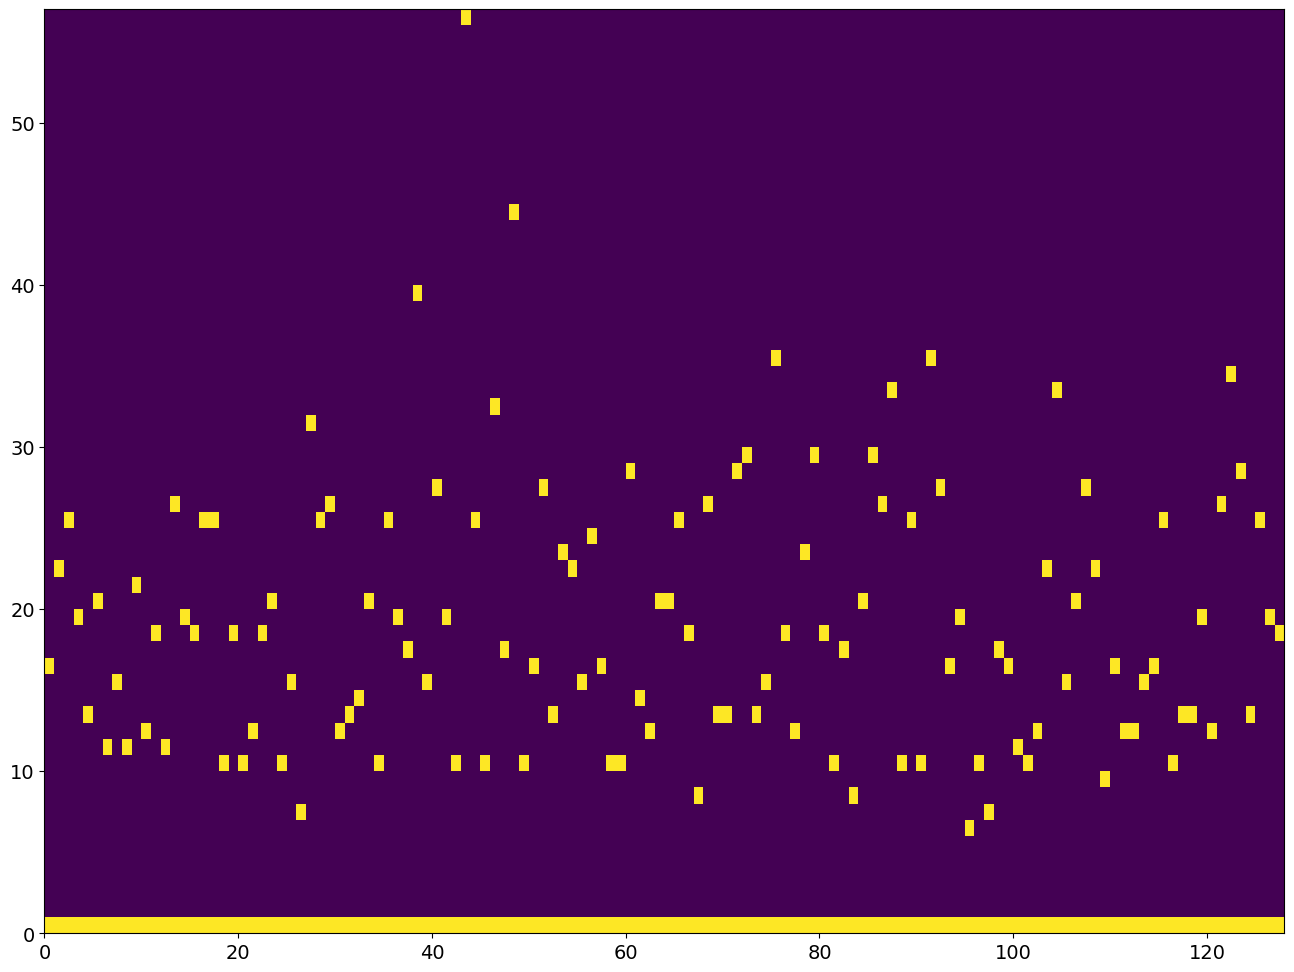

In [ ]:
plt.pcolormesh((en_batch == tokenizer_source.token_to_id(EOS_TOKEN)) | (en_batch == tokenizer_source.token_to_id(BOS_TOKEN)))

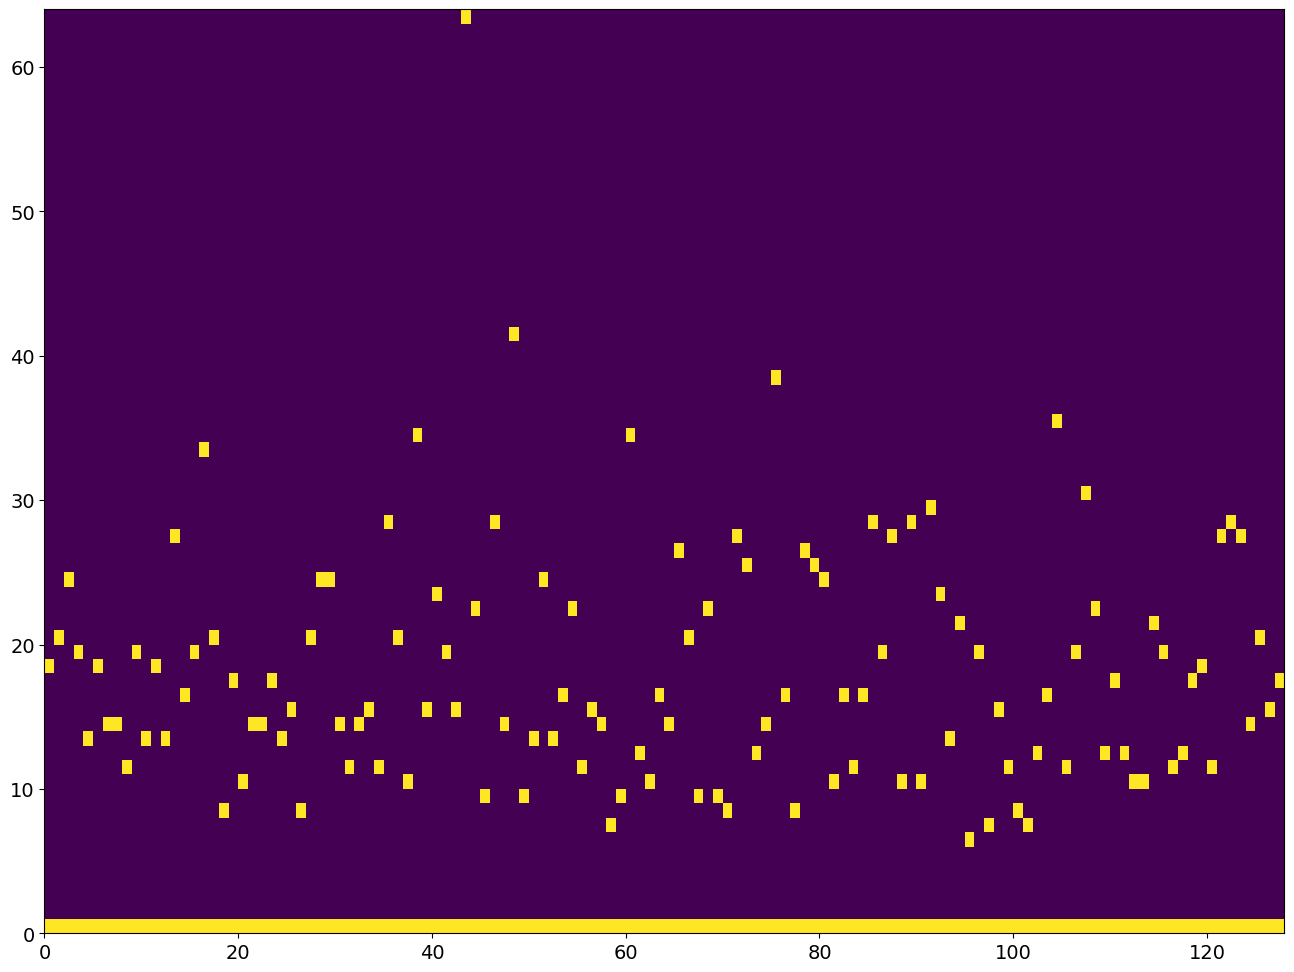

In [ ]:
plt.pcolormesh((ru_batch == tokenizer_target.token_to_id(EOS_TOKEN)) | (ru_batch == tokenizer_target.token_to_id(BOS_TOKEN)))

In [ ]:
import simple_seq2seq

In [ ]:
Encoder = simple_seq2seq.Encoder
Decoder = simple_seq2seq.Decoder
Seq2Seq = simple_seq2seq.Seq2Seq

In [ ]:
INPUT_DIM = tokenizer_source.get_vocab_size()
OUTPUT_DIM = tokenizer_target.get_vocab_size()
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LR = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7302, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10044, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=10044, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
summary(model, input_data=[en_batch, ru_batch])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [64, 128, 10044]          --
├─Encoder: 1-1                           [2, 128, 512]             --
│    └─Embedding: 2-1                    [57, 128, 256]            1,869,312
│    └─Dropout: 2-2                      [57, 128, 256]            --
│    └─LSTM: 2-3                         [57, 128, 512]            3,678,208
├─Decoder: 1-2                           [128, 10044]              --
│    └─Embedding: 2-4                    [1, 128, 256]             2,571,264
│    └─Dropout: 2-5                      [1, 128, 256]             --
│    └─LSTM: 2-6                         [1, 128, 512]             3,678,208
│    └─Linear: 2-7                       [128, 10044]              5,152,572
├─Decoder: 1-3                           [128, 10044]              (recursive)
│    └─Embedding: 2-8                    [1, 128, 256]             (recursive)
│    └─Dropout: 2-9             

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_target.token_to_id(PAD_TOKEN))

In [ ]:
def compute_metrics(eval_preds, tokenizer_target=tokenizer_target):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer_target.decode_batch(preds)

    decoded_labels = tokenizer_target.decode_batch(labels)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return result["bleu"]

In [ ]:
def train(model, iterator, optimizer, criterion, clip, tokenizer_target=tokenizer_target, train_history=None, valid_history=None):
    model.train()

    history = {
        'loss': [],
        'grad_norm': [],
        'metric': []
    }
    for i, (src, trg) in tqdm(enumerate(iterator), total=len(iterator)):
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        output_pred = output.argmax(dim=-1).transpose(0, 1).detach().cpu().tolist()
        output_label = trg.transpose(0, 1).detach().cpu().tolist()
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].reshape(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        history['loss'].append(loss.item())
        history['grad_norm'].append(get_grad_norm(model.named_parameters()))
        history['metric'].append(compute_metrics((output_pred, output_label), tokenizer_target=tokenizer_target))
        if (i+1)%100==0:
            fig, ax = plt.subplots(nrows=2, ncols=2)

            clear_output(True)
            ax[0][0].plot(history['loss'], label='train loss')
            ax[0][0].set_xlabel('Batch')
            ax[0][0].set_title('Train loss')

            ax[0][1].plot(history['grad_norm'], label='grad norms')
            ax[0][1].set_xlabel('Batch')
            ax[0][1].set_title('Gradient norms')

            if train_history is not None:
                ax[1][0].plot(train_history['loss'], label='general train loss')
                ax[1][0].set_xlabel('Epoch')
                ax[1][1].plot(train_history['metric'], label='general train metric')
                ax[1][1].set_title('BLEU')
                ax[1][1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1][0].plot(valid_history['loss'], label='general valid loss')
                ax[1][1].plot(valid_history['metric'], label='general valid metric')
            plt.legend()
            
            plt.show()

        
    return sum(history['loss']) / len(iterator), sum(history['metric']) / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, tokenizer_target=tokenizer_target):
    
    model.eval()
    
    epoch_loss = 0
    epoch_metric = 0
    
    with torch.no_grad():
    
        for i, (src, trg) in tqdm(enumerate(iterator), total=len(iterator)):
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing
            output_pred = output.argmax(dim=-1).transpose(0, 1).detach().cpu().tolist()
            output_label = trg.transpose(0, 1).detach().cpu().tolist()

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].reshape(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            batch_metric = compute_metrics((output_pred, output_label), tokenizer_target=tokenizer_target)
            epoch_metric += batch_metric
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), epoch_metric / len(iterator)

In [ ]:
train_history = {
    'loss': [],
    'metric': []
}
valid_history = {
    'loss': [],
    'metric': []
}

N_EPOCHS = 30
CLIP = 0.7

best_valid_metric = 0
early_stopping = EarlyStopping(patience=3, verbose=True, path=f'{dir}/model.pt')

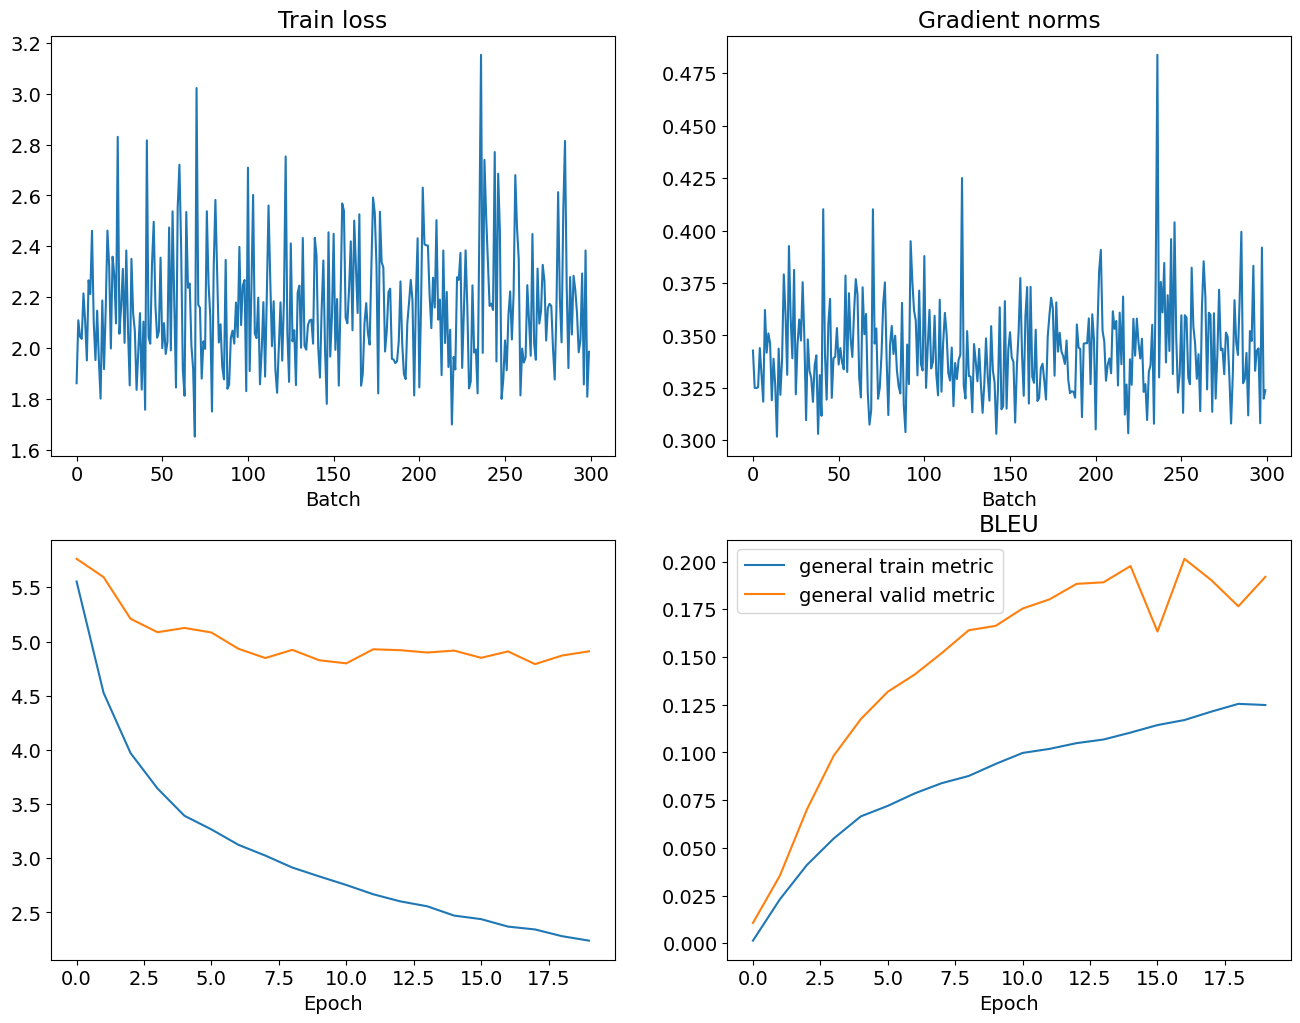

100%|██████████| 40/40 [00:06<00:00,  6.03it/s]

EarlyStopping counter: 4 out of 4
Early stopping


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_metric = train(model, train_iter, optimizer, criterion, CLIP, tokenizer_target, train_history, valid_history)
    valid_loss, valid_metric = evaluate(model, val_iter, criterion, tokenizer_target)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    early_stopping(valid_metric, model)
    
    train_history['loss'].append(train_loss)
    valid_history['loss'].append(valid_loss)
    train_history['metric'].append(train_metric)
    valid_history['metric'].append(valid_metric)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train BLEU: {train_metric:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | Val. BLEU: {valid_metric:.3f}')

# Bidirectional + pretrained embeddings Glove

In [ ]:
dir = '/content/gdrive/MyDrive/nlp_tranlsation_bidirectional_glove'

In [ ]:
!mkdir -p $dir

In [ ]:
tokenizer_source.save(path=f'{dir}/tokenizer_source.json')

In [ ]:
tokenizer_target.save(path=f'{dir}/tokenizer_target.json')

In [ ]:
import bidirectional_seq2seq

In [ ]:
Encoder = bidirectional_seq2seq.Encoder
Decoder = bidirectional_seq2seq.Decoder
Seq2Seq = bidirectional_seq2seq.Seq2Seq

In [ ]:
INPUT_DIM = tokenizer_source.get_vocab_size()
OUTPUT_DIM = tokenizer_target.get_vocab_size()
ENC_EMB_DIM = 300
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LR = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
vec = torchtext.vocab.GloVe(name='6B', dim=ENC_EMB_DIM)

In [ ]:
embeddings = vec.get_vecs_by_tokens(
    list(dict(sorted(tokenizer_source.get_vocab().items(), key=lambda x:x[1])).keys()),
    lower_case_backup=True)

In [ ]:
assert embeddings[tokenizer_source.token_to_id(PAD_TOKEN)].equal(torch.zeros(ENC_EMB_DIM))
assert embeddings[tokenizer_source.token_to_id(BOS_TOKEN)].equal(torch.zeros(ENC_EMB_DIM))

In [ ]:
tot_transferred = 0
for v in embeddings:
    if not v.equal(torch.zeros(ENC_EMB_DIM)):
        tot_transferred += 1
        
print(f'tokens were successfully transferred: {tot_transferred / tokenizer_source.get_vocab_size() * 100:.2f}%')

tokens were successfully transferred: 94.15%


In [ ]:
for i in range(tokenizer_source.get_vocab_size()):
    if embeddings[i].equal(torch.zeros(ENC_EMB_DIM)):
        embeddings[i] = torch.randn(ENC_EMB_DIM)

In [ ]:
enc.embedding = nn.Embedding(
    INPUT_DIM,
    ENC_EMB_DIM,
    padding_idx=tokenizer_source.token_to_id(PAD_TOKEN),
    _weight=embeddings.to(device),
    _freeze=False,
)

In [ ]:
assert model.encoder.embedding.padding_idx == tokenizer_source.token_to_id(PAD_TOKEN)
assert model.encoder.embedding.weight.equal(embeddings.to(device))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_target.token_to_id(PAD_TOKEN))

In [ ]:
with torch.no_grad():
    model(en_batch.to(device), ru_batch.to(device))

In [ ]:
train_history = {
    'loss': [],
    'metric': []
}
valid_history = {
    'loss': [],
    'metric': []
}

N_EPOCHS = 30
CLIP = 0.7

best_valid_metric = 0
early_stopping = EarlyStopping(patience=4, verbose=True, path=f'{dir}/model.pt')

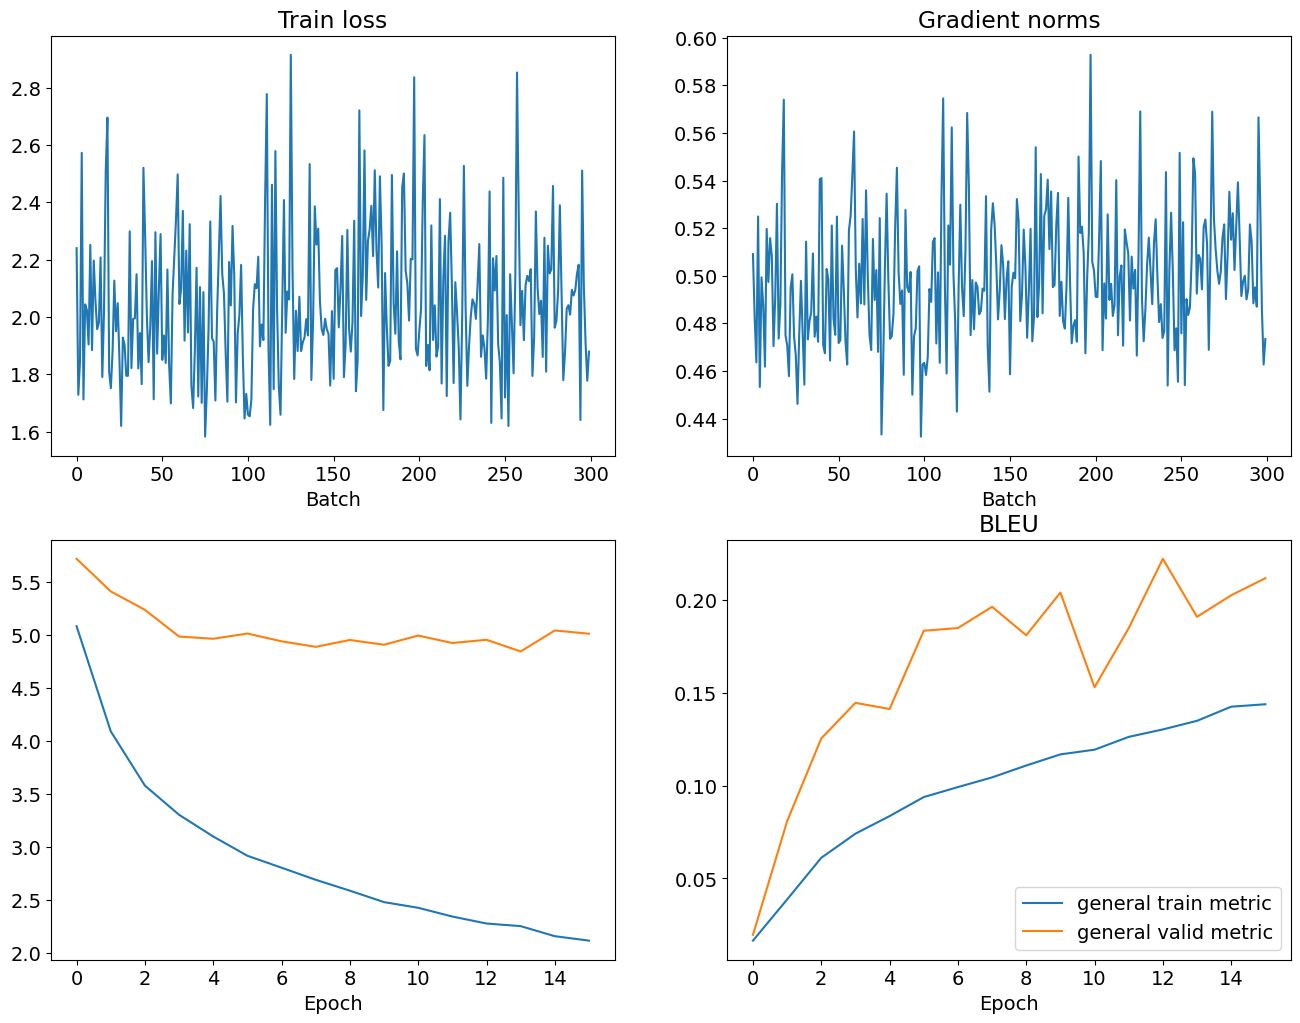

100%|██████████| 40/40 [00:06<00:00,  6.13it/s]

EarlyStopping counter: 4 out of 4
Early stopping


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_metric = train(model, train_iter, optimizer, criterion, CLIP, tokenizer_target, train_history, valid_history)
    valid_loss, valid_metric = evaluate(model, val_iter, criterion, tokenizer_target)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    early_stopping(valid_metric, model)
    
    train_history['loss'].append(train_loss)
    valid_history['loss'].append(valid_loss)
    train_history['metric'].append(train_metric)
    valid_history['metric'].append(valid_metric)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train BLEU: {train_metric:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | Val. BLEU: {valid_metric:.3f}')

# Attention + BPETokenizer

In [ ]:
dir = '/content/gdrive/MyDrive/nlp_tranlsation_attention_bpe'

In [ ]:
!mkdir -p $dir

In [ ]:
tokenizer_source = tokenizers.Tokenizer(tokenizers.models.BPE(unk_token=UNK_TOKEN))
tokenizer_target = tokenizers.Tokenizer(tokenizers.models.BPE(unk_token=UNK_TOKEN))
trainer = tokenizers.trainers.BpeTrainer(min_frequency=MIN_TOKEN_FREQ, special_tokens=[UNK_TOKEN, BOS_TOKEN, EOS_TOKEN, PAD_TOKEN])

In [ ]:
tokenizer_source.normalizer = tokenizers.normalizers.Lowercase()
tokenizer_source.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
tokenizer_target.normalizer = tokenizers.normalizers.Lowercase()
tokenizer_target.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

In [ ]:
en_generator = dataset_generator(train_test_dataset['train'], 'en')
ru_generator = dataset_generator(train_test_dataset['train'], 'ru')

In [ ]:
tokenizer_source.train_from_iterator(en_generator, trainer)
tokenizer_target.train_from_iterator(ru_generator, trainer)

In [ ]:
tokenizer_source.enable_padding(pad_id=tokenizer_source.token_to_id(PAD_TOKEN), pad_token=PAD_TOKEN)
tokenizer_target.enable_padding(pad_id=tokenizer_target.token_to_id(PAD_TOKEN), pad_token=PAD_TOKEN)
tokenizer_source.post_processor = tokenizers.processors.TemplateProcessing(single=f"{BOS_TOKEN} $0 {EOS_TOKEN}", 
                                                                           special_tokens=[(BOS_TOKEN, tokenizer_source.token_to_id(BOS_TOKEN)),
                                                                                           (EOS_TOKEN, tokenizer_source.token_to_id(EOS_TOKEN))]
                                                                           )
tokenizer_target.post_processor = tokenizers.processors.TemplateProcessing(single=f"{BOS_TOKEN} $0 {EOS_TOKEN}", 
                                                                           special_tokens=[(BOS_TOKEN, tokenizer_target.token_to_id(BOS_TOKEN)),
                                                                                           (EOS_TOKEN, tokenizer_target.token_to_id(EOS_TOKEN))]
                                                                           )

In [ ]:
print(f"Unique tokens in source (en) vocabulary: {tokenizer_source.get_vocab_size()}")
print(f"Unique tokens in target (ru) vocabulary: {tokenizer_target.get_vocab_size()}")

Unique tokens in source (en) vocabulary: 13879
Unique tokens in target (ru) vocabulary: 20011


In [ ]:
tokenizer_source.save(path=f'{dir}/tokenizer_source.json')

In [ ]:
tokenizer_target.save(path=f'{dir}/tokenizer_target.json')

In [ ]:
for row in train_test_dataset['train']['translation'][:5]:
    original_en = row['en']
    original_ru = row['ru']
    encode_en = tokenizer_source.encode(original_en).ids
    encode_ru = tokenizer_target.encode(original_ru).ids
    decode_en = tokenizer_source.decode(encode_en, skip_special_tokens=False)
    decode_ru = tokenizer_target.decode(encode_ru, skip_special_tokens=False)
    print(f"""
        en original: {original_en}
        en encode: {encode_en}
        en decode: {decode_en}
        ru original: {original_ru}
        ru encode: {encode_ru}
        ru decode: {decode_ru}
    """)


        en original: The apartments have a sofa.
        en encode: [1, 175, 451, 425, 33, 812, 16, 2]
        en decode: [BOS] the apartments have a sofa . [EOS]
        ru original: Кроме того, в апартаментах установлен диван.
        ru encode: [1, 632, 485, 15, 128, 657, 611, 1862, 17, 2]
        ru decode: [BOS] кроме того , в апартаментах установлен диван . [EOS]
    

        en original: The apartment features a living area with a TV, a washing machine, 2 bedrooms and a bathroom.
        en encode: [1, 175, 299, 365, 33, 626, 308, 195, 33, 269, 14, 33, 828, 620, 14, 20, 1051, 177, 33, 311, 16, 2]
        en decode: [BOS] the apartment features a living area with a tv , a washing machine , 2 bedrooms and a bathroom . [EOS]
        ru original: В вашем распоряжении апартаменты с 2 спальнями, ванной комнатой, стиральной машиной и гостиной зоной с телевизором.
        ru encode: [1, 128, 1074, 450, 381, 143, 21, 1778, 15, 354, 719, 15, 1578, 746, 134, 960, 1001, 143, 438, 17, 2]
 

In [ ]:
def generate_batch(data_batch):
    en_encoded_batch = tokenizer_source.encode_batch(
        [row['translation']['en'] for row in data_batch]
    )
    ru_encoded_batch = tokenizer_target.encode_batch(
        [row['translation']['ru'] for row in data_batch]
    )
    en_batch = torch.tensor([item.ids for item in en_encoded_batch])
    ru_batch = torch.tensor([item.ids for item in ru_encoded_batch])
    return en_batch.transpose(0, 1), ru_batch.transpose(0, 1)

train_iter = DataLoader(train_test_dataset['train'], batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
val_iter = DataLoader(train_test_dataset['test'], batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)

In [ ]:
train_iter = DataLoader(train_test_dataset['train'], batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
val_iter = DataLoader(train_test_dataset['test'], batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)

In [ ]:
en_batch, ru_batch = next(iter(train_iter))

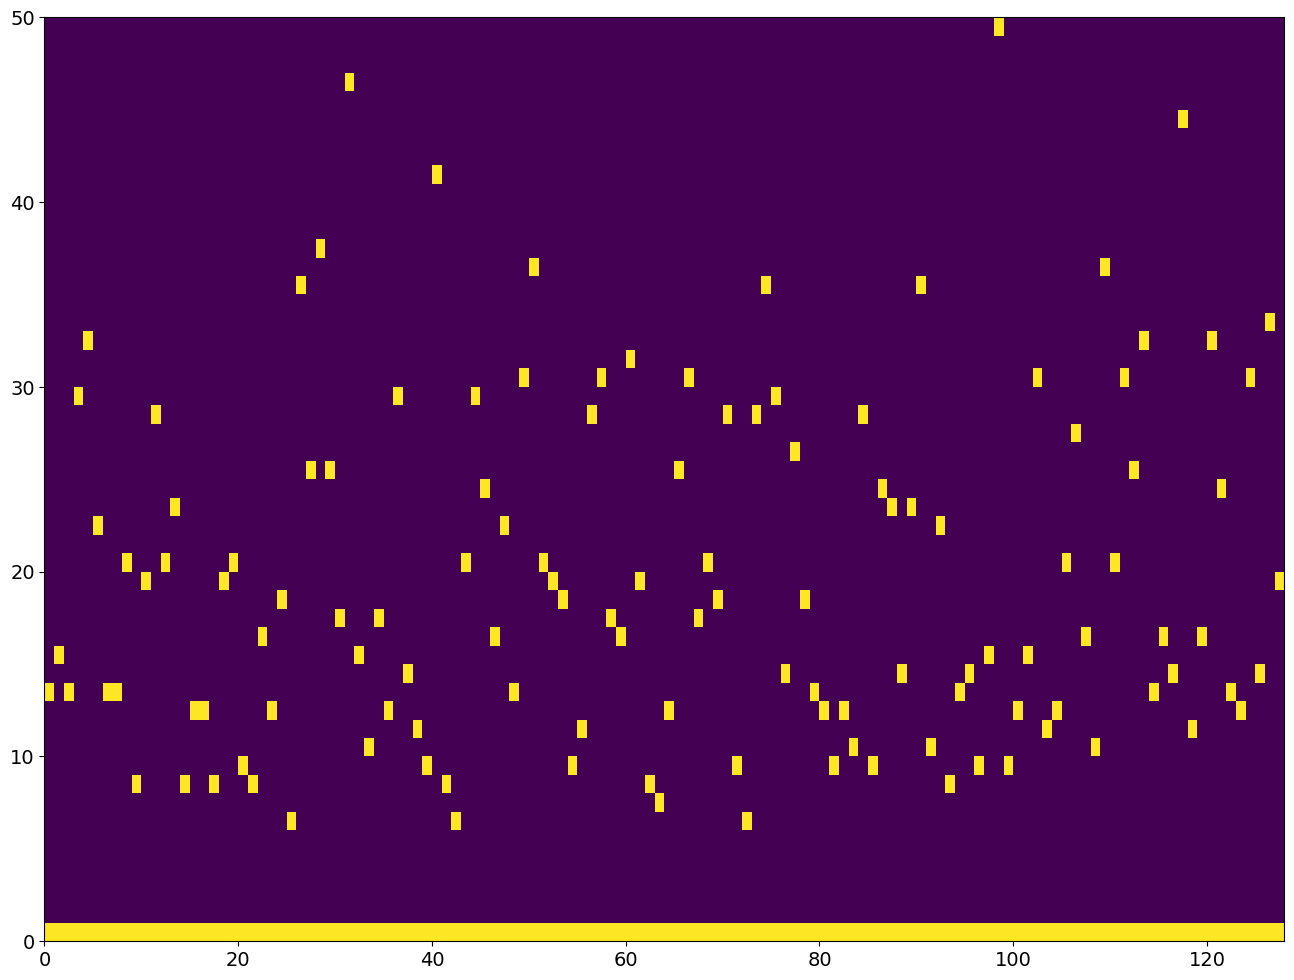

In [ ]:
plt.pcolormesh((en_batch == tokenizer_source.token_to_id(EOS_TOKEN)) | (en_batch == tokenizer_source.token_to_id(BOS_TOKEN)))

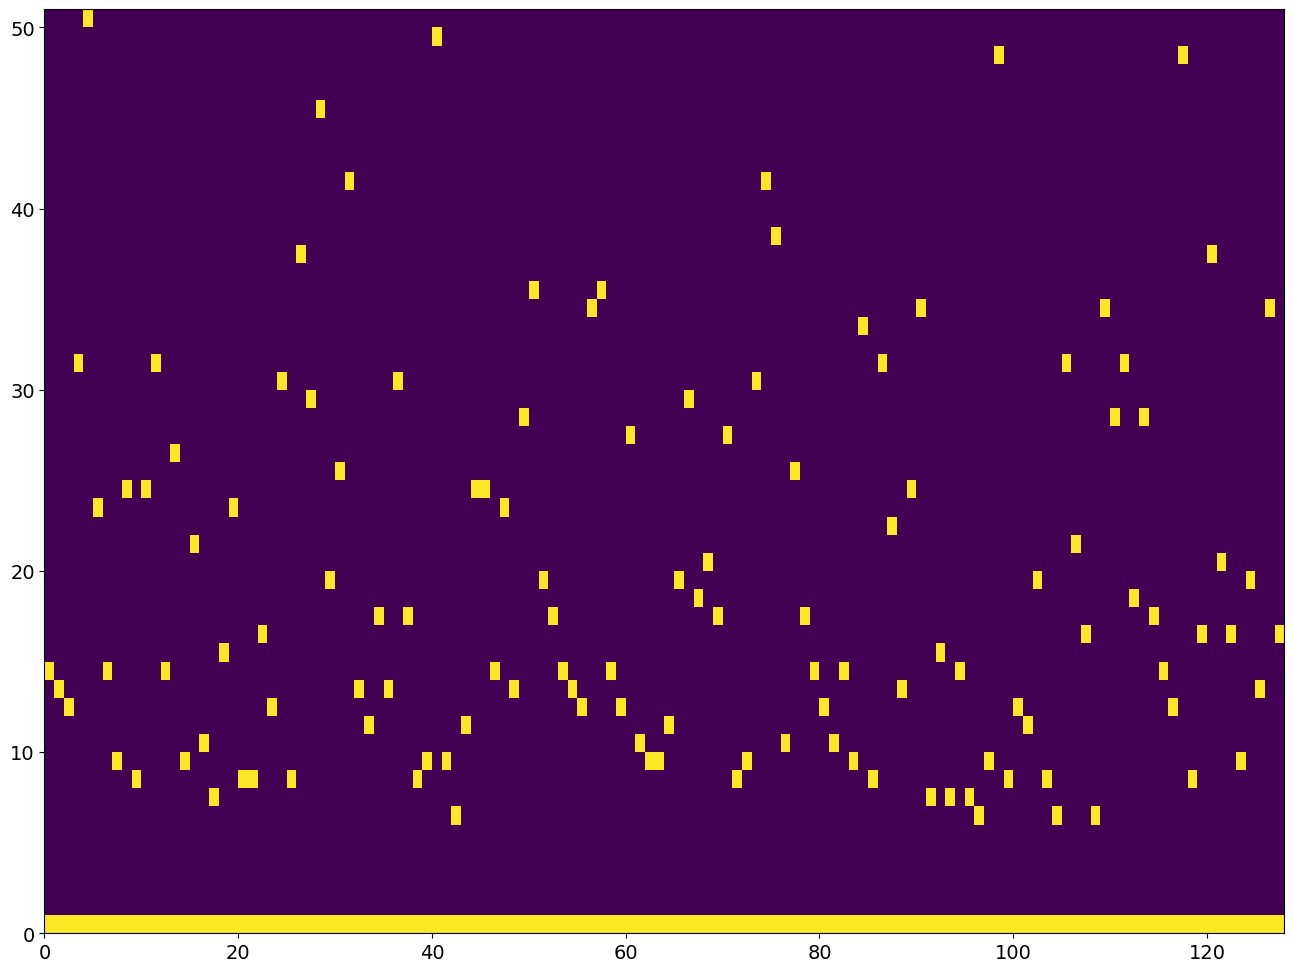

In [ ]:
plt.pcolormesh((ru_batch == tokenizer_target.token_to_id(EOS_TOKEN)) | (ru_batch == tokenizer_target.token_to_id(BOS_TOKEN)))

In [ ]:
import attention_seq2seq

In [ ]:
INPUT_DIM = tokenizer_source.get_vocab_size()
OUTPUT_DIM = tokenizer_target.get_vocab_size()
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LR = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

attn = attention_seq2seq.Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = attention_seq2seq.Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = attention_seq2seq.Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = attention_seq2seq.Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(13879, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(20011, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=20011, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_target.token_to_id(PAD_TOKEN))

In [ ]:
train_history = {
    'loss': [],
    'metric': []
}
valid_history = {
    'loss': [],
    'metric': []
}

N_EPOCHS = 30
CLIP = 0.7

best_valid_metric = 0
early_stopping = EarlyStopping(patience=3, verbose=True, path=f'{dir}/model.pt')

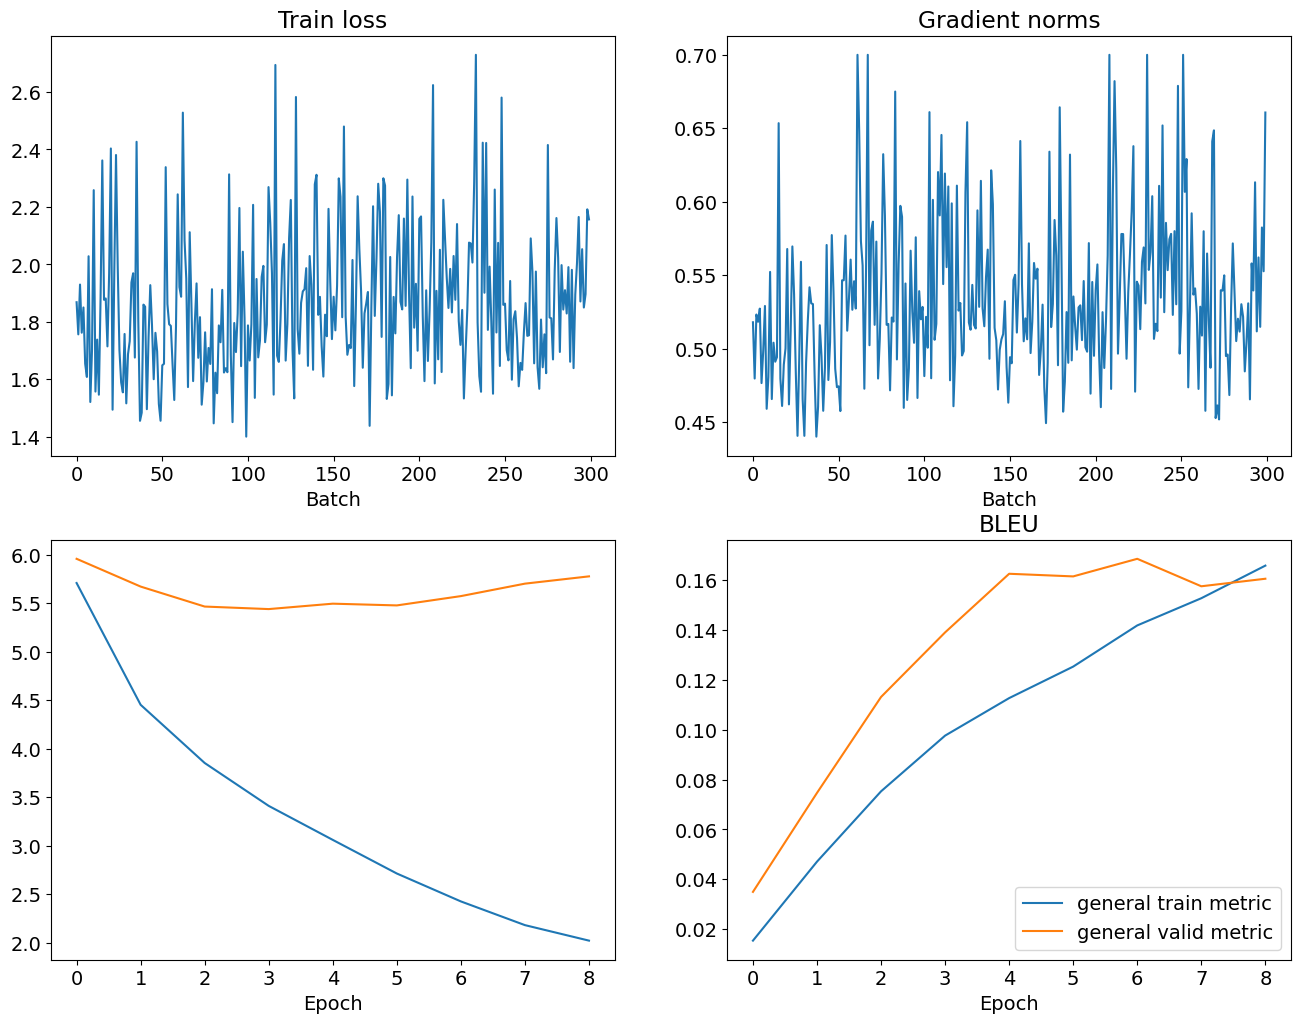

100%|██████████| 40/40 [00:13<00:00,  2.96it/s]

EarlyStopping counter: 3 out of 3
Early stopping


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_metric = train(model, train_iter, optimizer, criterion, CLIP, tokenizer_target, train_history, valid_history)
    valid_loss, valid_metric = evaluate(model, val_iter, criterion, tokenizer_target)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    early_stopping(valid_metric, model)
    
    train_history['loss'].append(train_loss)
    valid_history['loss'].append(valid_loss)
    train_history['metric'].append(train_metric)
    valid_history['metric'].append(valid_metric)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train BLEU: {train_metric:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | Val. BLEU: {valid_metric:.3f}')

# Bert2GPT from scratch

In [ ]:
dir = '/content/gdrive/MyDrive/nlp_tranlsation_bert2gpt_scratch'

In [ ]:
!mkdir -p $dir

In [ ]:
en_generator = dataset_generator(train_test_dataset['train'], 'en')
ru_generator = dataset_generator(train_test_dataset['train'], 'ru')

In [ ]:
tokenizer_source = BertWordPieceTokenizer()
tokenizer_target = ByteLevelBPETokenizer()

In [ ]:
tokenizer_source.train_from_iterator(en_generator, min_frequency=MIN_TOKEN_FREQ)
tokenizer_target.train_from_iterator(ru_generator, min_frequency=MIN_TOKEN_FREQ, special_tokens=[UNK_TOKEN, BOS_TOKEN, EOS_TOKEN, PAD_TOKEN])

In [ ]:
tokenizer_source.save_model(dir, "BertWordPieceTokenizer")

['/content/gdrive/MyDrive/nlp_tranlsation_bert2gpt_scratch/BertWordPieceTokenizer-vocab.txt']

In [ ]:
tokenizer_target.save_model(dir, "ByteLevelBPETokenizer")

['/content/gdrive/MyDrive/nlp_tranlsation_bert2gpt_scratch/ByteLevelBPETokenizer-vocab.json',
 '/content/gdrive/MyDrive/nlp_tranlsation_bert2gpt_scratch/ByteLevelBPETokenizer-merges.txt']

In [ ]:
tokenizer_source = BertTokenizer(
    f'{dir}/BertWordPieceTokenizer-vocab.txt',
    unk_token=UNK_TOKEN,
    pad_token=PAD_TOKEN,
)
GPT2Tokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
tokenizer_target = GPT2Tokenizer(
    f'{dir}/ByteLevelBPETokenizer-vocab.json',
    f'{dir}/ByteLevelBPETokenizer-merges.txt',
    unk_token=UNK_TOKEN,
    bos_token=BOS_TOKEN,
    eos_token=EOS_TOKEN,
    pad_token=PAD_TOKEN,
)

In [ ]:
tokenizer_source.decode(tokenizer_source('I am Dima').input_ids)

'[CLS] i am dima [SEP]'

In [ ]:
tokenizer_target.decode(tokenizer_target('Меня зовут Дима').input_ids)

'Меня зовут Дима[EOS]'

In [ ]:
def map_to_length(x):
  x["source_len"] = len(tokenizer_source(x["translation"]['en']).input_ids)
  x["source_longer_32"] = int(x['source_len'] > 32)
  x["source_longer_64"] = int(x['source_len'] > 64)
  x["target_len"] = len(tokenizer_source(x["translation"]['ru']).input_ids)
  x["target_longer_32"] = int(x['target_len'] > 32)
  x["target_longer_64"] = int(x['target_len'] > 64)
  x["target_longer_128"] = int(x['target_len'] > 128)
  return x

In [ ]:
data_stats = train_test_dataset['train'].map(map_to_length, num_proc=4)

Map (num_proc=4):   0%|          | 0/45000 [00:00<?, ? examples/s]

In [ ]:
def compute_and_print_stats(x):
    print(
        "Source Mean: {}, %-Source > 64:{}, %-Source > 128:{},\n Target Mean:{}, %-Target > 32:{}, %-Target > 64:{}, , %-Target > 128:{}".format(
            sum(x["source_len"]) / len(train_test_dataset['train']),
            sum(x["source_longer_32"]) / len(train_test_dataset['train']),
            sum(x["source_longer_64"]) / len(train_test_dataset['train']),
            sum(x["target_len"]) / len(train_test_dataset['train']),
            sum(x["target_longer_32"]) / len(train_test_dataset['train']),
            sum(x["target_longer_64"]) / len(train_test_dataset['train']),
            sum(x["target_longer_128"]) / len(train_test_dataset['train']),
        )
    )

output = data_stats.map(
  compute_and_print_stats, 
  batched=True,
  batch_size=-1,
)

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Source Mean: 19.714844444444445, %-Source > 64:0.08535555555555556, %-Source > 128:0.0006888888888888888,
 Target Mean:51.21651111111111, %-Target > 32:0.7794444444444445, %-Target > 64:0.24131111111111112, , %-Target > 128:0.010288888888888889


In [ ]:
encoder_max_length = 64
decoder_max_length = 128

In [ ]:
def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = [row['en'] for row in batch["translation"]]
  outputs = [row['ru'] for row in batch["translation"]]
  inputs = tokenizer_source(inputs, padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer_target(outputs, padding="max_length", truncation=True, max_length=decoder_max_length)
  
  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
#   batch["decoder_input_ids"] = outputs.input_ids
  batch["labels"] = outputs.input_ids.copy()
  batch["decoder_attention_mask"] = outputs.attention_mask
  # complicated list comprehension here because pad_token_id alone is not good enough to know whether label should be excluded or not
  batch["labels"] = [
      [-100 if mask == 0 else token for mask, token in mask_and_tokens] for mask_and_tokens in [zip(masks, labels) for masks, labels in zip(batch["decoder_attention_mask"], batch["labels"])]
  ]
  assert all([len(x) == encoder_max_length for x in inputs.input_ids])
  assert all([len(x) == decoder_max_length for x in outputs.input_ids])


  return batch

In [ ]:
batch_size=128

train_data = train_test_dataset['train'].map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["id", "translation"]
)

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

In [ ]:
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_attention_mask", "labels"],
)

In [ ]:
val_data = train_test_dataset['test'].map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["id", "translation"]
)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_attention_mask", "labels"],
)

In [ ]:
bert_config = BertConfig(
    vocab_size = len(tokenizer_source),
    max_position_embeddings=encoder_max_length + 32,
    num_attention_heads=4,
    num_hidden_layers=4,
    hidden_size=256,
    type_vocab_size=1
)

In [ ]:
gpt_config = GPT2Config(
    vocab_size=len(tokenizer_target),
    n_positions=decoder_max_length + 32,
    n_embd=256,
    n_layer=4,
    n_head=4,
    add_cross_attention=True
)

In [ ]:
encoder = BertModel(config=bert_config)
decoder = GPT2LMHeadModel(config=gpt_config)

In [ ]:
model = EncoderDecoderModel(encoder=encoder, decoder=decoder)

In [ ]:
model.config.decoder_start_token_id = tokenizer_target.bos_token_id
model.config.eos_token_id = tokenizer_target.eos_token_id
model.config.pad_token_id = tokenizer_target.pad_token_id
model.config.max_length = decoder_max_length+32

In [ ]:
generation_config = GenerationConfig(
    bos_token_id=tokenizer_target.bos_token_id,
    eos_token_id=tokenizer_target.eos_token_id,
    max_length=decoder_max_length+32,
    pad_token_id=tokenizer_target.pad_token_id,
    num_beams=2,
    early_stopping=True
)

In [ ]:
model.generation_config = generation_config

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    decoded_preds = tokenizer_target.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer_target.pad_token_id
    decoded_labels = tokenizer_target.batch_decode(labels_ids, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {
        "BLEU": result['bleu']
    }


In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy='epoch',
    num_train_epochs = 30,
    learning_rate = 1e-4,
    optim='adamw_torch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./bert2gpt_scratch",
    logging_steps=300,
    metric_for_best_model='BLEU',
    load_best_model_at_end=True
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Epoch,Training Loss,Validation Loss,Bleu
1,6.683000,4.896934,0.053826
2,4.603900,3.970305,0.117571
3,3.922700,3.542657,0.146825
4,3.553300,3.283380,0.151784
5,3.290700,3.116835,0.176731
6,2.951200,2.982566,0.190373
7,2.816900,2.885150,0.215770
8,2.708800,2.810100,0.229636
9,2.605800,2.747204,0.237213
10,2.540100,2.700917,0.241881


/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no ne

TrainOutput(global_step=8096, training_loss=2.6752086910805684, metrics={'train_runtime': 2379.534, 'train_samples_per_second': 567.338, 'train_steps_per_second': 4.438, 'total_flos': 4627040993280000.0, 'train_loss': 2.6752086910805684, 'epoch': 23.0})

In [ ]:
res = trainer.predict(val_data)

/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [ ]:
res

PredictionOutput(predictions=array([[   1,  336,  694, ...,    3,    3,    3],
       [   1,  411,  454, ...,    3,    3,    3],
       [   1, 1919,  685, ...,    3,    3,    3],
       ...,
       [   1,  571,  520, ...,    3,    3,    3],
       [   1,  336,  569, ...,    3,    3,    3],
       [   1,  336, 2161, ...,    3,    3,    3]]), label_ids=array([[ 336,  694,  569, ...,    3,    3,    3],
       [ 603, 3237,  810, ...,    3,    3,    3],
       [1919,  685,  725, ...,    3,    3,    3],
       ...,
       [ 571,  520,  918, ...,    3,    3,    3],
       [ 336, 3397,  710, ...,    3,    3,    3],
       [ 336, 2161,  431, ...,    3,    3,    3]]), metrics={'test_loss': 2.4916441440582275, 'test_BLEU': 0.269201118181669, 'test_runtime': 40.9513, 'test_samples_per_second': 122.096, 'test_steps_per_second': 0.977})

In [ ]:
predict = tokenizer_target.batch_decode(res.predictions, skip_special_tokens=True)

In [ ]:
for i in range(10):
    print(f"en: {train_test_dataset['test'][i]['translation']['en']}")
    print(f"ru_origin: {train_test_dataset['test'][i]['translation']['ru']}")
    print(f'ru_predict: {predict[i]}')
    print('#'*100)

en: Featuring a bath, the private bathroom also comes with a hairdryer.
ru_origin: В собственной ванной комнате с ванной предоставляется фен.
ru_predict: В собственной ванной комнате с ванной предоставляется фен.
####################################################################################################
en: It offers a balcony with stunning views to the Aegean Sea and the famous sunset.
ru_origin: С балкона открывается потрясающий вид на Эгейское море и знаменитый закат.
ru_predict: К услугам гостей балкон с панорамным видом на Эгейское море и живописный вид на Эгейское море.
####################################################################################################
en: Danae Apartments staff are available 24 hours a day, and can assist you with luggage storage.
ru_origin: Сотрудники апартаментов Danae работают круглосуточно и помогут организовать хранение багажа.
ru_predict: Сотрудники апартаментов All помогут гостям с круглосуточной стойкой регистрации и камерой хра

In [ ]:
trainer.save_model(dir)

# Bert2GPT pretrained and larger

In [ ]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = token_ids_0 + [self.eos_token_id]
    return outputs

In [ ]:
tokenizer_source = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    unk_token=UNK_TOKEN,
    pad_token=PAD_TOKEN,)
GPT2Tokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
tokenizer_target = GPT2Tokenizer.from_pretrained('ai-forever/rugpt3small_based_on_gpt2',
    unk_token=UNK_TOKEN,
    bos_token=BOS_TOKEN,
    eos_token=EOS_TOKEN,
    pad_token=PAD_TOKEN)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokenizer_source.decode(tokenizer_source('I am Dima').input_ids)

'[CLS] i am dima [SEP]'

In [ ]:
tokenizer_target.decode(tokenizer_target('Меня зовут Дима').input_ids)

'Меня зовут Дима [EOS]'

In [ ]:
tokenizer_source.save_pretrained('/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_source')

('/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_source/tokenizer_config.json',
 '/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_source/special_tokens_map.json',
 '/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_source/vocab.txt',
 '/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_source/added_tokens.json')

In [ ]:
tokenizer_target.save_pretrained('/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_target')

('/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_target/tokenizer_config.json',
 '/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_target/special_tokens_map.json',
 '/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_target/vocab.json',
 '/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_target/merges.txt',
 '/content/gdrive/MyDrive/nlp_tranlsation/tokenizer_target/added_tokens.json')

In [ ]:
def map_to_length(x):
  x["source_len"] = len(tokenizer_source(x["translation"]['en']).input_ids)
  x["source_longer_32"] = int(x['source_len'] > 32)
  x["source_longer_64"] = int(x['source_len'] > 64)
  x["target_len"] = len(tokenizer_source(x["translation"]['ru']).input_ids)
  x["target_longer_32"] = int(x['target_len'] > 32)
  x["target_longer_64"] = int(x['target_len'] > 64)
  x["target_longer_128"] = int(x['target_len'] > 128)
  return x

In [ ]:
data_stats = train_test_dataset['train'].map(map_to_length, num_proc=4)

In [ ]:
def compute_and_print_stats(x):
    print(
        "Source Mean: {}, %-Source > 64:{}, %-Source > 128:{},\n Target Mean:{}, %-Target > 32:{}, %-Target > 64:{}, , %-Target > 128:{}".format(
            sum(x["source_len"]) / len(train_test_dataset['train']),
            sum(x["source_longer_32"]) / len(train_test_dataset['train']),
            sum(x["source_longer_64"]) / len(train_test_dataset['train']),
            sum(x["target_len"]) / len(train_test_dataset['train']),
            sum(x["target_longer_32"]) / len(train_test_dataset['train']),
            sum(x["target_longer_64"]) / len(train_test_dataset['train']),
            sum(x["target_longer_128"]) / len(train_test_dataset['train']),
        )
    )

output = data_stats.map(
  compute_and_print_stats, 
  batched=True,
  batch_size=-1,
)

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Source Mean: 20.72102222222222, %-Source > 64:0.11033333333333334, %-Source > 128:0.0008888888888888889,
 Target Mean:79.23302222222222, %-Target > 32:0.9659777777777778, %-Target > 64:0.5847555555555556, , %-Target > 128:0.09773333333333334


In [ ]:
encoder_max_length = 128
decoder_max_length = 64

In [ ]:
def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = [row['en'] for row in batch["translation"]]
  outputs = [row['ru'] for row in batch["translation"]]
  inputs = tokenizer_source(inputs, padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer_target(outputs, padding="max_length", truncation=True, max_length=decoder_max_length)
  
  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
#   batch["decoder_input_ids"] = outputs.input_ids
  batch["labels"] = outputs.input_ids.copy()
  batch["decoder_attention_mask"] = outputs.attention_mask
  # complicated list comprehension here because pad_token_id alone is not good enough to know whether label should be excluded or not
  batch["labels"] = [
      [-100 if mask == 0 else token for mask, token in mask_and_tokens] for mask_and_tokens in [zip(masks, labels) for masks, labels in zip(batch["decoder_attention_mask"], batch["labels"])]
  ]
  assert all([len(x) == encoder_max_length for x in inputs.input_ids])
  assert all([len(x) == decoder_max_length for x in outputs.input_ids])


  return batch

In [ ]:
batch_size=64

train_data = train_test_dataset['train'].map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["id", "translation"]
)

In [ ]:
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_attention_mask", "labels"],
)

In [ ]:
val_data = train_test_dataset['test'].map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["id", "translation"]
)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_attention_mask", "labels"],
)

In [ ]:
bert2gpt = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "ai-forever/rugpt3small_based_on_gpt2")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at ai-forever/rugpt3small_based_on_gpt2 and are newly initialized: ['transfo

In [ ]:
for param in bert2gpt.encoder.parameters():
    param.requires_grad = False

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The Encoder has {count_parameters(bert2gpt.encoder):,} trainable parameters')
print(f'The Decoder has {count_parameters(bert2gpt.decoder):,} trainable parameters')

The Encoder has 0 trainable parameters
The Decoder has 153,598,464 trainable parameters


In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    decoded_preds = tokenizer_target.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer_target.pad_token_id
    decoded_labels = tokenizer_target.batch_decode(labels_ids, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {
        "BLEU": result['bleu']
    }


In [ ]:
generation_config = GenerationConfig(
    bos_token_id=tokenizer_target.bos_token_id,
    eos_token_id=tokenizer_target.eos_token_id,
    max_length=decoder_max_length+32,
    pad_token_id=tokenizer_target.pad_token_id,
    num_beams=2,
    early_stopping=True
)

In [ ]:
bert2gpt.config.decoder_start_token_id = tokenizer_target.bos_token_id
bert2gpt.config.eos_token_id = tokenizer_target.eos_token_id
bert2gpt.config.pad_token_id = tokenizer_target.pad_token_id
bert2gpt.config.max_length = decoder_max_length + 32

In [ ]:
bert2gpt.generation_config = generation_config

In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    save_strategy='steps',
    eval_steps = 500,
    num_train_epochs = 10,
    learning_rate = 5e-4,
    lr_scheduler_type = "linear",
    warmup_steps = 90,
    weight_decay = 0.01,
    optim='adamw_torch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./bert2gpt_pretrained/",
    logging_steps=500,
    metric_for_best_model='BLEU',
    load_best_model_at_end=True
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=bert2gpt,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Bleu
500,2.164800,1.703393,0.204188
1000,1.503000,1.503749,0.257590
1500,1.254900,1.443067,0.269714
2000,0.993600,1.372526,0.280869
2500,0.785600,1.428716,0.284253
3000,0.677100,1.522385,0.281720
3500,0.571000,1.486886,0.294578
4000,0.428500,1.581137,0.293477
4500,0.377200,1.631506,0.295041
5000,0.322900,1.675004,0.297485


/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no ne

KeyboardInterrupt: ignored

In [ ]:
res = trainer.predict(val_data)

/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Bleu
500,2.164800,1.703393,0.204188
1000,1.503000,1.503749,0.257590
1500,1.254900,1.443067,0.269714
2000,0.993600,1.372526,0.280869
2500,0.785600,1.428716,0.284253
3000,0.677100,1.522385,0.281720
3500,0.571000,1.486886,0.294578
4000,0.428500,1.581137,0.293477
4500,0.377200,1.631506,0.295041
5000,0.322900,1.675004,0.297485


In [ ]:
res

PredictionOutput(predictions=array([[50257,   677,  6905, ..., 50259, 50259, 50259],
       [50257,   563, 40528, ..., 50259, 50259, 50259],
       [50257, 42945,   945, ..., 50259, 50259, 50259],
       ...,
       [50257,  2176,  2923, ..., 50259, 50259, 50259],
       [50257,   677, 16272, ..., 50259, 50259, 50259],
       [50257,  1009,  3283, ..., 50259, 50259, 50259]]), label_ids=array([[  677,  6905, 16272, ..., 50259, 50259, 50259],
       [  563, 40528, 20351, ..., 50259, 50259, 50259],
       [42945,   945,  1157, ..., 50259, 50259, 50259],
       ...,
       [ 2176,  2923, 11584, ..., 50259, 50259, 50259],
       [  677,  5690,   411, ..., 50259, 50259, 50259],
       [  677,  1927, 13278, ..., 50259, 50259, 50259]]), metrics={'test_loss': 1.6789391040802002, 'test_BLEU': 0.29812745295051996, 'test_runtime': 156.7114, 'test_samples_per_second': 31.906, 'test_steps_per_second': 0.504})

In [ ]:
predict = tokenizer_target.batch_decode(res.predictions, skip_special_tokens=True)

In [ ]:
for i in range(10):
    print(f"en: {train_test_dataset['test'][i]['translation']['en']}")
    print(f"ru_origin: {train_test_dataset['test'][i]['translation']['ru']}")
    print(f'ru_predict: {predict[i]}')
    print('#'*100)

en: Featuring a bath, the private bathroom also comes with a hairdryer.
ru_origin: В собственной ванной комнате с ванной предоставляется фен.
ru_predict: В собственной ванной комнате с ванной предоставляется фен.
####################################################################################################
en: It offers a balcony with stunning views to the Aegean Sea and the famous sunset.
ru_origin: С балкона открывается потрясающий вид на Эгейское море и знаменитый закат.
ru_predict: С балкона открывается потрясающий вид на Эгейское море и неповторимый закат.
####################################################################################################
en: Danae Apartments staff are available 24 hours a day, and can assist you with luggage storage.
ru_origin: Сотрудники апартаментов Danae работают круглосуточно и помогут организовать хранение багажа.
ru_predict: Сотрудники круглосуточной стойки регистрации будут рады помочь гостям с арендой багажа.
#######################

In [ ]:
trainer.save_model('/content/gdrive/MyDrive/nlp_tranlsation/')

# Results

## imports and classes

In [297]:
import simple_seq2seq
import bidirectional_seq2seq
import attention_seq2seq

In [298]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [299]:
class Rnn:
    def generate(self, batch):
        with torch.no_grad():
            inp = [row['en'] for row in batch['translation']]
            inputs = self.tokenizer_source.encode_batch(inp)
            input_ids = torch.tensor([item.ids for item in inputs]).to(device).transpose(0, 1)
            trg = torch.zeros(self.max_length, input_ids.shape[1], dtype=torch.int32)
            trg[0, :] = self.tokenizer_target.token_to_id(BOS_TOKEN)
            trg = trg.to(device)
            output = self.model(input_ids, trg, 0) #turn off teacher forcing
            output_pred = output.argmax(dim=-1).transpose(0, 1).detach().cpu().tolist()
            filtered_predict = []
            for lst in output_pred:
                try:
                    index = lst.index(self.tokenizer_target.token_to_id(EOS_TOKEN))
                except ValueError:
                    filtered_predict.append(lst)
                else:
                    filtered_predict.append(lst[:index + 1])
            output_str = self.tokenizer_target.decode_batch(filtered_predict, skip_special_tokens=True)
            batch["pred_summary"] = output_str

        return batch

In [300]:
class Transformer:
    def generate(self, batch):
        inp = [row['en'] for row in batch['translation']]
        inputs = self.tokenizer_source(inp, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        input_ids = inputs.input_ids.to(device)
        attention_mask = inputs.attention_mask.to(device)

        outputs = self.model.generate(input_ids, attention_mask=attention_mask)
        output_str = self.tokenizer_target.batch_decode(outputs, skip_special_tokens=True)
        batch["pred_summary"] = output_str

        return batch

In [301]:
class Baseline(Rnn):
    def __init__(self):
        self.path = '/content/gdrive/MyDrive/nlp_tranlsation_baseline'
        self.tokenizer_source = tokenizers.Tokenizer.from_file(f'{self.path}/tokenizer_source.json')
        self.tokenizer_target = tokenizers.Tokenizer.from_file(f'{self.path}/tokenizer_target.json')
        self.max_length = 64
        self.init_model()

    def init_model(self):
        Encoder = simple_seq2seq.Encoder
        Decoder = simple_seq2seq.Decoder
        Seq2Seq = simple_seq2seq.Seq2Seq
        input_dim = self.tokenizer_source.get_vocab_size()
        output_dim = self.tokenizer_target.get_vocab_size()
        enc_emb_dim = 256
        dec_emb_dim = 256
        hid_dim = 512
        n_layers = 2
        enc_dropout = 0.5
        dec_dropout = 0.5
        enc = Encoder(input_dim, enc_emb_dim, hid_dim, n_layers, enc_dropout)
        dec = Decoder(output_dim, dec_emb_dim, hid_dim, n_layers, dec_dropout)

        self.model = Seq2Seq(enc, dec, device)
        checkpoint = torch.load(f'{self.path}/model.pt')
        self.model.load_state_dict(checkpoint)
        self.model = self.model.to(device)
        self.model.eval()


In [302]:
class Bidirectional(Rnn):
    def __init__(self):
        self.path = '/content/gdrive/MyDrive/nlp_tranlsation_bidirectional_glove'
        self.tokenizer_source = tokenizers.Tokenizer.from_file(f'{self.path}/tokenizer_source.json')
        self.tokenizer_target = tokenizers.Tokenizer.from_file(f'{self.path}/tokenizer_target.json')
        self.max_length = 64
        self.init_model()

    def init_model(self):
        Encoder = bidirectional_seq2seq.Encoder
        Decoder = bidirectional_seq2seq.Decoder
        Seq2Seq = bidirectional_seq2seq.Seq2Seq
        input_dim = self.tokenizer_source.get_vocab_size()
        output_dim = self.tokenizer_target.get_vocab_size()
        enc_emb_dim = 300
        dec_emb_dim = 256
        enc_hid_dim = 512
        dec_hid_dim = 512
        enc_dropout = 0.5
        dec_dropout = 0.5
        enc = Encoder(input_dim, enc_emb_dim, enc_hid_dim, dec_hid_dim, enc_dropout)
        dec = Decoder(output_dim, dec_emb_dim, dec_hid_dim, dec_dropout)

        self.model = Seq2Seq(enc, dec, device)
        checkpoint = torch.load(f'{self.path}/model.pt')
        self.model.load_state_dict(checkpoint)
        self.model = self.model.to(device)
        self.model.eval()


In [303]:
class Attention(Rnn):
    def __init__(self):
        self.path = '/content/gdrive/MyDrive/nlp_tranlsation_attention_bpe'
        self.tokenizer_source = tokenizers.Tokenizer.from_file(f'{self.path}/tokenizer_source.json')
        self.tokenizer_target = tokenizers.Tokenizer.from_file(f'{self.path}/tokenizer_target.json')
        self.max_length = 64
        self.init_model()

    def init_model(self):
        input_dim = self.tokenizer_source.get_vocab_size()
        output_dim = self.tokenizer_target.get_vocab_size()
        enc_emb_dim = 256
        dec_emb_dim = 256
        enc_hid_dim = 512
        dec_hid_dim = 512
        enc_dropout = 0.5
        dec_dropout = 0.5
        attn = attention_seq2seq.Attention(enc_hid_dim, dec_hid_dim)
        enc = attention_seq2seq.Encoder(input_dim, enc_emb_dim, enc_hid_dim, dec_hid_dim, enc_dropout)
        dec = attention_seq2seq.Decoder(output_dim, dec_emb_dim, enc_hid_dim, dec_hid_dim, dec_dropout, attn)

        self.model = attention_seq2seq.Seq2Seq(enc, dec, device)
        checkpoint = torch.load(f'{self.path}/model.pt')
        self.model.load_state_dict(checkpoint)
        self.model = self.model.to(device)
        self.model.eval()


In [304]:
class Bert2GptScratch(Transformer):
    def __init__(self, is_rl=False):
        self.path = '/content/gdrive/MyDrive/nlp_tranlsation_bert2gpt_scratch'
        self.model = EncoderDecoderModel.from_pretrained(self.path).to(device)
        if is_rl:
            checkpoint = torch.load(f'{self.path}/rl.pt')
            self.model.load_state_dict(checkpoint)
        self.model.eval()
        self.max_length = 64
        self.tokenizer_source = BertTokenizer(
            f'{self.path}/BertWordPieceTokenizer-vocab.txt',
            unk_token=UNK_TOKEN,
            pad_token=PAD_TOKEN,
        )
        self.tokenizer_target = GPT2Tokenizer(
            f'{self.path}/ByteLevelBPETokenizer-vocab.json', 
            f'{self.path}/ByteLevelBPETokenizer-merges.txt',
            unk_token=UNK_TOKEN,
            bos_token=BOS_TOKEN,
            eos_token=EOS_TOKEN,
            pad_token=PAD_TOKEN,
        )
 
        self.model.generation_config = GenerationConfig.from_pretrained(
            self.path,
        )
        self.model.generation_config.early_stopping = False

In [305]:
class Bert2GptPretrained(Transformer):
    def __init__(self):
        self.path = '/content/gdrive/MyDrive/nlp_tranlsation'
        self.model = EncoderDecoderModel.from_pretrained(self.path).to(device)
        self.model.eval()
        self.max_length = 128
        self.tokenizer_source = AutoTokenizer.from_pretrained(f'{self.path}/tokenizer_source')
        self.tokenizer_target = AutoTokenizer.from_pretrained(f'{self.path}/tokenizer_target')
 
        self.model.generation_config = GenerationConfig.from_pretrained(
            self.path,
        )
        self.model.generation_config.early_stopping = False

In [306]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

## Small Bert2GPT Reinforcement Learning

In [276]:
bert2gpt = Bert2GptScratch()
gleu = evaluate.load("google_bleu")
bleu = evaluate.load("bleu")

In [251]:
!pip install undecorated

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [277]:
from undecorated import undecorated
from types import MethodType

generate_with_grad = undecorated(bert2gpt.model.generate)
bert2gpt.model.generate_with_grad = MethodType(generate_with_grad, bert2gpt.model)

In [253]:
import torch.nn.functional as F

In [229]:
def infer_mask(seq, eos_ix, batch_first=True, include_eos=True, dtype=torch.float):
    """
    compute length given output indices and eos code
    :param seq: tf matrix [time,batch] if batch_first else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :param include_eos: if True, the time-step where eos first occurs is has mask = 1
    :returns: lengths, int32 vector of shape [batch]
    """
    assert seq.dim() == 2
    is_eos = (seq == eos_ix).to(dtype=torch.float)
    if include_eos:
        if batch_first:
            is_eos = torch.cat((is_eos[:,:1]*0, is_eos[:, :-1]), dim=1)
        else:
            is_eos = torch.cat((is_eos[:1,:]*0, is_eos[:-1, :]), dim=0)
    count_eos = torch.cumsum(is_eos, dim=1 if batch_first else 0)
    mask = count_eos == 0
    return mask.to(dtype=dtype)

In [230]:
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data
    y_tensor = y_tensor.to(dtype=torch.long).reshape(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims, device=y.device).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.reshape(*y.shape, -1)
    return y_one_hot

In [231]:
def compute_reward(input_sequence, translations, tokenizer_target=bert2gpt.tokenizer_target):
    """ computes sample-wise reward given token ids for inputs and translations """
    output_str = tokenizer_target.batch_decode(input_sequence, skip_special_tokens=True)
    reward = []
    for i in range(len(translations)):
        score = gleu.compute(predictions=[output_str[i]], references=[[translations[i]]])
        reward.append(score['google_bleu'])
    return torch.tensor(reward)

In [232]:
def get_log_p(scores):
    logits_seq = []
    for score in scores:
        logits_seq.append(score)
    sample_logp = F.log_softmax(torch.stack(logits_seq, 1), dim=-1)
    return sample_logp

In [254]:
def scst_objective_on_batch(batch, model, tokenizer_target=bert2gpt.tokenizer_target, **sample_args):
    """ Compute pseudo-loss for policy gradient given a batch of sources """
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    greedy_translations = model.generate_with_grad(input_ids=input_ids, attention_mask=attention_mask, do_sample=False, num_beams=1)
    sample_result = model.generate_with_grad(input_ids=input_ids, attention_mask=attention_mask, 
                                        return_dict_in_generate=True, output_scores=True, **sample_args)
    # use model to __sample__ symbolic translations given input_sequence
    sample_translations = sample_result.sequences[:, 1:]
    sample_logp = get_log_p(sample_result.scores)
    # use model to __greedy__ symbolic translations given input_sequence

    # compute rewards and advantage
    # be careful with the device, rewards require casting to numpy, so send everything to cpu
    rewards = compute_reward(sample_translations, batch["outputs"], tokenizer_target)
    baseline = compute_reward(greedy_translations, batch["outputs"], tokenizer_target) # <compute __negative__ levenshtein for greedy mode >
    # compute advantage using rewards and baseline
    # be careful with the device, advantage is used to compute gradients, so send it to device
    advantage = (rewards - baseline).float().to(device)  # YOUR CODE
    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    logp_sample = torch.sum(to_one_hot(sample_translations, n_dims=len(tokenizer_target)) * sample_logp, dim=-1)
        # YOUR CODE
    
    # ^-- hint: look at how crossentropy is implemented in supervised learning loss above
    # mind the sign - this one should not be multiplied by -1 :)

    # policy gradient pseudo-loss. Gradient of J is exactly policy gradient.
    J = logp_sample * advantage[:, None]

    assert J.dim() == 2, "please return elementwise objective, don't compute mean just yet"

    # average with mask
    mask = infer_mask(sample_translations, tokenizer_target.eos_token_id)
    loss = - torch.sum(J * mask) / torch.sum(mask)


    # regularize with negative entropy. Don't forget the sign!
    # note: for entropy you need probabilities for all tokens (sample_logp), not just logp_sample
    entropy = -torch.sum(torch.exp(sample_logp) * sample_logp, dim=-1)
    # <compute entropy matrix of shape[batch, seq_length], H = -sum(p*log_p), don't forget the sign!>
    # hint: you can get sample probabilities from sample_logp using math :)

    assert entropy.dim(
    ) == 2, "please make sure elementwise entropy is of shape [batch,time]"

    reg = - 1e-6 * torch.sum(entropy * mask) / torch.sum(mask)

    return loss + reg, torch.sum(entropy * mask) / torch.sum(mask)

In [255]:
batch_size = 64

In [256]:
encoder_max_length = 64
decoder_max_length = 128

In [278]:
def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = [row['en'] for row in batch["translation"]]
  outputs = [row['ru'] for row in batch["translation"]]
  inputs = bert2gpt.tokenizer_source(inputs, padding="max_length", truncation=True, max_length=bert2gpt.max_length, return_tensors="pt")
  
  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["outputs"] = outputs

  return batch

In [279]:
train_data = train_test_dataset['train'].map(
    process_data_to_model_inputs, 
    batched=True, 
    remove_columns=["id", "translation"]
)

In [280]:
val_data = train_test_dataset['test'].map(
    process_data_to_model_inputs, 
    batched=True, 
    remove_columns=["id", "translation"]
)

In [281]:
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "outputs"],
)
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "outputs"],
)

In [282]:
train_generation = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True)
val_generation = DataLoader(val_data, batch_size=128, num_workers=2, shuffle=False)

In [283]:
bert2gpt.model.train()
opt = torch.optim.Adam(bert2gpt.model.parameters(), lr=1e-5)

In [284]:
generation_dict = {
    'do_sample': True,
    'num_beams': 1,
    'top_k': 0, 
    'temperature': 0.7
    # 'top_p': 0.92, 
}

In [285]:
epochs = 3
early_stopping = EarlyStopping(patience=4, verbose=True, path=f'/content/gdrive/MyDrive/model.pt')

In [286]:
bert2gpt.model.generation_config

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "max_length": 160,
  "num_beams": 2,
  "pad_token_id": 3,
  "transformers_version": "4.28.1"
}


Val metric 0.2779725544826733:  85%|████████▌ | 599/703 [27:28<03:18,  1.91s/it]

EarlyStopping counter: 4 out of 4


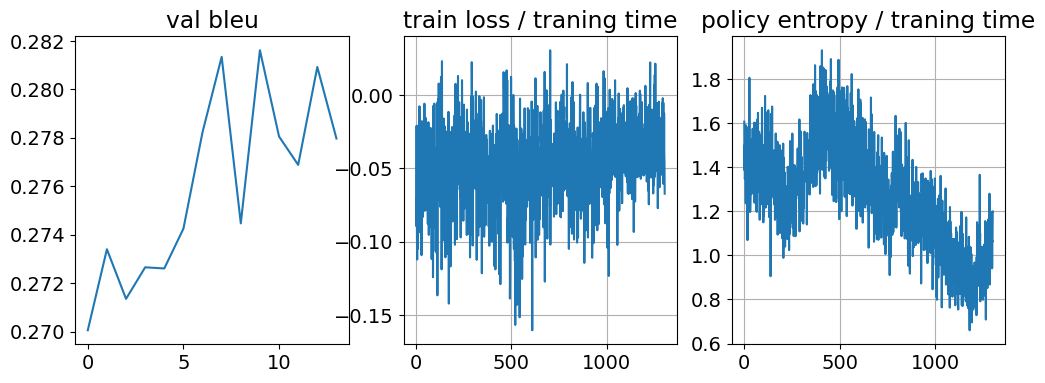

Val metric 0.2779725544826733:  86%|████████▌ | 604/703 [27:38<04:31,  2.75s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:24                                                                             │
│ in scst_objective_on_batch:5                                                                     │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1437 in generate        │
│                                                                                                  │
│   1434 │   │   │   │   )                                                                         │
│   1435 │   │   │                                                                                 │
│   1436 │   │   │   # 11. run greedy search                                                       │
│ ❱ 1437 │   │   │   return self.greedy_search(                                                    │
│   1438 │   │   │   │   input_ids,                                                                │
│   1439 │   │   │   │   logits_processor=logits_processor,                                        │
│   1440 │   │   │   │   stopping_criteria=stopping_criteria,                                      │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:2248 in greedy_search   │
│                                                                                                  │
│   2245 │   │   │   model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)  │
│   2246 │   │   │                                                                                 │
│   2247 │   │   │   # forward pass to get next token                                              │
│ ❱ 2248 │   │   │   outputs = self(                                                               │
│   2249 │   │   │   │   **model_inputs,                                                           │
│   2250 │   │   │   │   return_dict=True,                                                         │
│   2251 │   │   │   │   output_attentions=output_attentions,                                      │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1110 in _call_impl            │
│                                                                                                  │
│   1107 │   │   # this function, and just call forward.                                           │
│   1108 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1109 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1110 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1111 │   │   # Do not call functions when jit is used                                          │
│   1112 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1113 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_dec │
│ oder.py:617 in forward                                                                           │
│                                                                                                  │
│   614 │   │   │   )                                                                              │
│   615 │   │                                                                                      │
│   616 │   │   # Decode                                     

In [287]:
loss_history = []
entropy_history = []
val_reward = []
REPORT_FREQ = 100
is_start = True
for _ in range(epochs):
    for i, input in (pbar := tqdm(enumerate(train_generation), total=int(len(train_data) / batch_size))):
        if is_start:
            bert2gpt.model.eval()
            val_reward_batch = []
            for input_val in tqdm(val_generation):
                input_ids = input_val['input_ids'].to(device)
                attention_mask = input_val['attention_mask'].to(device)

                outputs = bert2gpt.model.generate(input_ids, attention_mask=attention_mask)
                output_str = bert2gpt.tokenizer_target.batch_decode(outputs, skip_special_tokens=True)
                score = bleu.compute(predictions=output_str, references=[[reference] for reference in input_val['outputs']])
                val_reward_batch.append(score['bleu'])
            val_reward.append(sum(val_reward_batch) / len(val_reward_batch))
            pbar.set_description(f"Val metric {val_reward[-1]}")
            early_stopping(val_reward[-1], bert2gpt.model)
            bert2gpt.model.train()
            is_start = False
        loss, ent = scst_objective_on_batch(input, bert2gpt.model, **generation_dict)
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        loss_history.append(loss.item())
        entropy_history.append(ent.item())
    
        if (i + 1) % REPORT_FREQ == 0:
            clear_output(True)
            val_reward_batch = []
            bert2gpt.model.eval()
            for input_val in tqdm(val_generation):
                input_ids = input_val['input_ids'].to(device)
                attention_mask = input_val['attention_mask'].to(device)

                outputs = bert2gpt.model.generate(input_ids, attention_mask=attention_mask)
                output_str = bert2gpt.tokenizer_target.batch_decode(outputs, skip_special_tokens=True)
                score = bleu.compute(predictions=output_str, references=[[reference] for reference in input_val['outputs']])
                val_reward_batch.append(score['bleu'])
            bert2gpt.model.train()
            val_reward.append(sum(val_reward_batch) / len(val_reward_batch))
            pbar.set_description(f"Val metric {val_reward[-1]}")
            early_stopping(val_reward[-1], bert2gpt.model)
            plt.figure(figsize=(12, 4))
            plt.subplot(131)
            plt.title('val bleu')
            plt.plot(val_reward)
            plt.subplot(132)
            plt.title('train loss / traning time')
            plt.plot(loss_history)
            plt.grid()
            plt.subplot(133)
            plt.title('policy entropy / traning time')
            plt.plot(entropy_history)
            plt.grid()
            plt.show()

## Results evaluation

1. simple seq2seq rnn - Использовалась обычная lstm2lstm модель
2. bidirectional rnn with pretrained decoder embeddings - двунаправленная GRU с использованием предобученных embeddings
3. attention seq2seq with BPE tokenizer - двунаправленная GRU с использованием BPE tokenizer, также был добавлен attention между encoder и decoder
4. bert2gpt trained from scratch with beam search - небольшие bert и gpt модели обученные с нуля, на inference использовался beam search, с num_beams=2
5. bert2gpt pretrained with beam search - относительно большие предобученные bert и gpt модели. Bert предобучен на английских текстах, GPT2 на русских. Также был использован beam search.
6. дообученная bert2bert из 4 пункта с использованием reinforcement learning. Reward - gleu между предсказанием и ожидаемым выходом. Не bleu т.к. если верить этой страничке https://huggingface.co/spaces/evaluate-metric/google_bleu gleu работает лучше для одного sample, что нам и нужно

In [316]:
results = {
    'model': [
        'simple seq2seq rnn',
        'bidirectional rnn with pretrained decoder embeddings',
        'attention seq2seq with BPE tokenizer',
        'small bert2gpt trained from scratch with beam search',
        'bert2gpt pretrained with beam search',
        'small bert2gpt finetuned using RL'
    ],
    'num_parameters': [],
    'bleu': [],
    'inference_time (s)': []
}

In [317]:
models = [Baseline, Bidirectional, Attention, Bert2GptScratch, Bert2GptPretrained, Bert2GptScratch]
translations = []

In [318]:
BATCH_SIZE = 128
bleu = evaluate.load("bleu")

In [319]:
for i, model_class in tqdm(enumerate(models)):
    if i == len(models) - 1:
        model = model_class(is_rl=True)
    else:
        model = model_class()
    results['num_parameters'].append(count_parameters(model.model))
    start_time = time.time()
    translation = train_test_dataset['test'].map(model.generate, batched=True, batch_size=BATCH_SIZE, load_from_cache_file=False)
    end_time = time.time()
    results['inference_time (s)'].append(round(end_time - start_time, 2))
    translations.append(translation)
    if isinstance(model, Rnn):
        references = [[row['ru'].lower()] for row in translation['translation']]
    else:
        references = [[row['ru']] for row in translation['translation']]
    predictions = translation['pred_summary']
    bleu_score = bleu.compute(predictions=predictions, references=references)
    results['bleu'].append(bleu_score['bleu'])

0it [00:00, ?it/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

1it [00:05,  5.80s/it]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

2it [00:11,  5.68s/it]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

3it [00:24,  9.22s/it]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

4it [01:46, 37.75s/it]Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (192) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
5it [04:02, 73.23s/it]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

6it [05:12, 52.15s/it]


In [320]:
import pandas as pd

In [321]:
df = pd.DataFrame(results)
df

,model,num_parameters,bleu,inference_time (s)
0,simple seq2seq rnn,16949564,0.161769,4.99
1,bidirectional rnn with pretrained decoder embe...,14122564,0.179760,4.84
2,attention seq2seq with BPE tokenizer,50988843,0.211277,12.13
3,small bert2gpt trained from scratch with beam ...,21717760,0.269416,80.28
4,bert2gpt pretrained with beam search,263080704,0.302868,128.42
5,small bert2gpt finetuned using RL,21717760,0.281223,69.08


Первое что хочется заметить: cильное отличие результата attention seq2seq with BPE tokenizer с тем что мы видели на графиках val при обучении, возможно тогда мы что-то сделали не так. В остальном результаты ожидаемые, как итог одна из моделей побила 30 bleu score.

Теперь давайте посмотрим на предсказания моделей

In [322]:
for i in range(5):
    print('#'*50)
    print('Input: ', translations[0][i]['translation']['en'])
    print('Expected prediction: ',  translations[0][i]['translation']['ru'])
    for j in range(len(results['model'])):
        print('Translation of', j, ':', translations[j][i]['pred_summary'])

##################################################
Input:  Featuring a bath, the private bathroom also comes with a hairdryer.
Expected prediction:  В собственной ванной комнате с ванной предоставляется фен.
Translation of 0 : в собственной ванной комнате с душем предоставляется фен .
Translation of 1 : в собственной ванной комнате с душем предоставляется фен .
Translation of 2 : в собственной ванной комнате установлена ванна и фен .
Translation of 3 : В собственной ванной комнате с ванной предоставляется фен.
Translation of 4 : В собственной ванной комнате с ванной предоставляется фен.
Translation of 5 : В собственной ванной комнате с ванной и феном.
##################################################
Input:  It offers a balcony with stunning views to the Aegean Sea and the famous sunset.
Expected prediction:  С балкона открывается потрясающий вид на Эгейское море и знаменитый закат.
Translation of 0 : из окон открывается вид на море и горы .
Translation of 1 : с балкона открывается ви

У моделей в основном проблемы с именами собственными. Предобученная bert2gpt переводит более красиво :), но также стоит заметить, что finetuned using RL smal bert2gpt переводить иногда лучше на глаз, хоть и не так как указано в ожидаемом переводе